## AI Hack - Crop Yield Challenge

**Challenge Description:**

For this challenge, you will be tackling one of the world's most important challenges: modelling crop yields. Climate change is having a big impact in global food security, whilst Earth's population, in particular, in the developing world, continues to grow. Extreme weather events can have significant [impacts](http://www.nature.com/articles/nclimate1832) on crops and there is (significant evidence)[https://www.metoffice.gov.uk/weather/climate/climate-and-extreme-weather] showing that, recently, extreme events have become (1) more extreme and (2) more frequent, making crop yield modelling a useful tool for policy makers and suppliers who are hoping to mitigate these devastating risks.

From a machine learning and statistical perspective, crop yield modelling is a challenging task that can be seen as a **weakly supervised learning** or **multiple instance learning** problem. For every year and census region (e.g. county), we can gather an abundance of features such as daily temperature, vegetation indices and soil moisture, but we only have access to 1 crop yield label. To perform regression, one usually requires the dataset $\{(x_i,y_i)\}_{i=1}^n$. In this case, however, we have $\{(\{x_{ij}\}_{j=1}^{N_i},y_i)\}_{i=1}^n$, where $N_i$ is the number of feature vectors available for label $y_i$. A naive approach would be to reduce to the former by averaging the covariates $\bar{x}_{i}=\sum_{j=1}^{N_i} x_{ij}$, but this may result in an enormous loss of information. 

Could you explore different approaches to modelling crop yields using the provided datasets?

**Data:**

You are provided with various cleaned datasets that are extracted from the State of Illinois, USA. 

- [ ] `IL_yield.csv` contains corn yields for various census counties in Illinois
- [ ] `illinois-counties.geojson` contains the geometries of counties in Illinois
- [ ] `EVI.csv` contains [Enhanced Vegetation Indices](https://en.wikipedia.org/wiki/Enhanced_vegetation_index) for pixels extract from [The Terra Moderate Resolution Imaging Spectroradiometer (MODIS) Vegetation Indices (MOD13Q1)](https://lpdaac.usgs.gov/products/mod13q1v006/) product, aggregated at the resolution of the pixels in the [The Terra and Aqua combined Moderate Resolution Imaging Spectroradiometer (MODIS) Land Cover Climate Modeling Grid (CMG) (MCD12C1)](https://lpdaac.usgs.gov/products/mcd12c1v006/) product that indicate `Majority_Land_Cover_Type_1` is a cropland. The EVI is observed every 16 days.
- `EVI_stacked.csv` is the same as `EVI.csv` except the data is stacked to include the EVI observations for each 16 days in the column.
- `ERA5.csv` contains 2m temperature readings from [ERA5 Renalaysis](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview), "the fifth generation ECMWF reanalysis for the global climate and weather for the past 4 to 7 decades". More information about the variable can be found in the link given.

**Recommended Reading:**
- https://ojs.aaai.org/index.php/AAAI/article/view/11172/11031&hl=en&sa=T&oi=gsb-gga&ct=res&cd=0&d=1880767705414439608&ei=6kgwYPHHCvGTy9YPmJeAsAk&scisig=AAGBfm0LS8pg3jC6MJQQE5-vz3M2kSQeDg
- https://aiforsocialgood.github.io/icml2019/accepted/track1/pdfs/20_aisg_icml2019.pdf
- http://proceedings.mlr.press/v80/ilse18a/ilse18a.pdf
- https://linkinghub.elsevier.com/retrieve/pii/S0034425711002926
- https://linkinghub.elsevier.com/retrieve/pii/S0034425719304791
- https://ieeexplore.ieee.org/document/9173550/
- https://royalsocietypublishing.org/doi/10.1098/rstb.2019.0510 
- http://www.nature.com/articles/nclimate1832
- http://www.nature.com/articles/nature16467
- https://royalsocietypublishing.org/doi/10.1098/rstb.2019.0510

**Suggestions:**

- [ ] It will be useful to make use of `pandas`, `geopandas` and `matplotlib` for data processing and visualisation.
- [ ] Be as creative and rigorous as possible with how you make use of the features.
- [ ] Try and take some time to read through the various papers on the recommended reading list.
- [ ] I recommend only using features between April - November 2015, as suggestioned by one of the papers on the list https://www.sciencedirect.com/science/article/pii/S0034425719304791?via%3Dihub. 


Good luck - we hope that you enjoy this challenge and look forward to seeing your submissions on Devpost!

In [1]:
!ls .

'AI Hack - Crop Yield Challenge.html'	      csv.zip
'AI Hack - Crop Yield Challenge.ipynb'	      df_clean.ipynb
 README_AI_Hack_21_Crop_Yield_Challenge.pdf   illinois-counties.geojson
 crops_yield				      stormdata.csv.zip


## An illustrative plot

In [26]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import tensorflow
import math
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [3]:
with zipfile.ZipFile('csv.zip', 'r') as zip_ref:
    zip_ref.extractall('crops_yield')

In [4]:
gdf = gpd.read_file("illinois-counties.geojson")
df = pd.read_csv("crops_yield/EVI_stacked.csv")

No handles with labels found to put in legend.


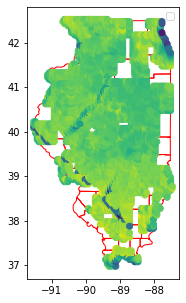

In [5]:
df_plot = df[df["year"]==2019]

fig, ax = plt.subplots(figsize=(5, 5))
gdf.plot(ax=ax, facecolor='none', edgecolor='red')

plt.scatter(df_plot["long"], df_plot["lat"], c=df_plot["evi_1"])
plt.legend()

In [6]:
yield_crop = pd.read_csv("crops_yield/IL_yield.csv")
yield_crop = yield_crop[(yield_crop["year"] > 2000)&(yield_crop["year"] < 2020)]
yield_crop

,year,county,yield
0,2019,LOGAN,194.2
1,2019,MACON,204.4
2,2019,MARSHALL,184.9
3,2019,MASON,169.0
4,2019,MCLEAN,198.8
...,...,...,...
1865,2001,MONTGOMERY,152.0
1866,2001,MORGAN,160.0
1867,2001,PIKE,156.0
1868,2001,SANGAMON,161.0


In [7]:
adam_yield = yield_crop[yield_crop["county"]=="ADAMS"]


In [8]:
yield_close = list(adam_yield["yield"])

In [9]:
vegetation = pd.read_csv("crops_yield/EVI_stacked.csv")
vegetation = vegetation[(vegetation["year"]>1990)&(vegetation["year"]<2020)]
vegetation

,year,county,long,lat,evi_1,evi_17,evi_33,evi_49,evi_65,evi_81,...,evi_209,evi_225,evi_241,evi_257,evi_273,evi_289,evi_305,evi_321,evi_337,evi_353
0,2001,ADAMS,-91.525,40.075,-0.146923,0.156453,-0.072903,-0.063690,-0.078860,-0.292650,...,-0.287875,0.127960,0.630331,0.057551,0.028800,0.224734,-0.037140,-0.054813,0.095283,0.132038
1,2001,ADAMS,-91.525,40.125,-0.156214,-0.188116,-0.091597,-0.109840,-0.099103,0.021988,...,0.226016,0.078727,-0.084846,0.029688,0.003740,-0.170605,-0.061510,-0.064935,-0.092197,-0.100994
2,2001,ADAMS,-91.525,40.175,0.000551,0.082851,0.108108,0.104726,0.101105,0.126727,...,0.455470,0.454312,0.411025,0.357470,0.320813,0.237779,0.165385,0.161586,0.142840,0.017134
3,2001,ADAMS,-91.525,40.225,-0.005583,0.084916,0.116382,0.115102,0.107363,0.130750,...,0.436069,0.462088,0.436204,0.374752,0.330077,0.250325,0.180660,0.169659,0.148152,0.017000
4,2001,ADAMS,-91.475,39.975,-0.030379,0.079086,0.107433,0.092655,0.078413,0.107965,...,0.544530,0.531395,0.461023,0.335277,0.239753,0.155304,0.102718,0.097096,0.079518,0.084052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95413,2019,WOODFORD,-88.975,40.875,0.104419,-0.036563,0.101393,0.092699,0.106869,0.122912,...,0.625691,0.686203,0.650799,0.520993,0.358112,0.226376,0.176463,0.161508,0.130636,0.117372
95414,2019,WOODFORD,-88.975,40.925,0.107272,-0.041136,0.090257,0.119536,0.109404,0.117849,...,0.612463,0.673483,0.637218,0.508683,0.357745,0.241118,0.164970,0.130541,0.129778,0.109219
95415,2019,WOODFORD,-88.925,40.825,0.107422,-0.039893,0.103312,0.089351,0.106749,0.120598,...,0.630736,0.684656,0.647539,0.525632,0.362510,0.218094,0.176306,0.171923,0.131405,0.113442
95416,2019,WOODFORD,-88.925,40.875,0.106712,-0.039885,0.101711,0.090369,0.109686,0.125570,...,0.606228,0.654604,0.608509,0.479529,0.334070,0.232092,0.193145,0.171825,0.129873,0.116098


In [13]:
yield_close[1]

197.8

In [10]:
plotted = vegetation[vegetation['county']=="ADAMS"]

In [15]:
columns=['evi_1','evi_17','evi_33','evi_49','evi_65','evi_81','evi_97','evi_113','evi_129','evi_145','evi_161','evi_177','evi_193','evi_209','evi_225','evi_241','evi_257','evi_273','evi_289','evi_305','evi_321','evi_337','evi_353']

index = list(range(0,26))
hello = []
years = []

j = 0
for i in range(2001,2019):
    add = list(plotted[plotted['year']==i].sum(axis=0))[4:27]
    stuff = yield_close[j]
    add.append(stuff)
    newList = [i]+add
    hello.append(newList)
    j+=1
    


    

In [16]:
columns = ['year','1','17','33','49','65','81','97','113','129','145','161','177','193','209','225','241','257','273','289','305','321','337','353','yield']
df = pd.DataFrame(data = hello,columns = columns)

In [17]:
df

,year,1,17,33,49,65,81,97,113,129,...,225,241,257,273,289,305,321,337,353,yield
0,2001,-3.227790,9.339349,12.852378,12.048392,11.814772,14.910878,20.435621,27.262671,36.722750,...,53.449126,42.829924,32.279208,27.581821,21.672481,17.402924,16.693676,15.551262,13.287348,168.1
1,2002,12.178049,12.917808,12.221240,11.958998,13.258824,16.576195,20.660122,27.514172,31.092039,...,54.294416,47.354660,35.035829,23.636041,20.207548,17.440158,13.530711,13.596839,11.519305,197.8
2,2003,12.633759,1.657488,9.976016,9.359812,9.683429,14.711115,20.315780,28.552018,33.696651,...,53.785964,44.894267,35.845704,26.084734,21.456636,18.047635,15.436712,9.655072,2.184900,192.2
3,2004,6.444367,6.620394,-0.177576,6.872122,7.655199,9.992213,12.552673,13.804615,17.695136,...,28.295398,20.188464,15.539829,13.362133,10.116026,8.708613,6.785866,7.577643,6.763327,193.1
4,2005,3.977900,11.834930,13.211746,12.715785,12.236018,13.324873,18.639038,27.651061,32.838989,...,48.824285,38.324980,28.600238,25.778447,23.413184,21.811586,15.233173,5.864116,7.327119,158.1
5,2006,12.978855,13.819835,13.108119,12.973357,13.801763,16.699518,21.631940,29.730596,33.790020,...,49.193857,43.322756,34.088809,24.732174,21.585108,15.858371,14.954164,18.011626,31.541752,202.4
6,2007,12.744439,1.108867,3.566402,12.923977,13.027560,22.871958,22.288384,22.660046,33.394349,...,46.651685,36.829670,25.127966,22.881890,22.032719,18.463073,16.682344,15.881640,9.850455,153.3
7,2008,12.492021,14.480369,11.982998,11.020465,12.898827,15.327227,17.645363,23.786384,31.126655,...,51.403488,48.691422,41.903070,29.650544,21.823354,19.664211,17.437997,16.029950,13.313488,76.0
8,2009,6.304868,7.585425,6.586876,6.983523,6.915946,7.972412,12.064212,15.706238,16.002203,...,27.255963,28.161517,25.763628,19.053683,12.027679,8.167994,7.218900,7.896254,-0.507711,135.8
9,2010,-1.842942,5.489225,6.489106,0.113616,3.595380,7.493140,12.226887,14.961551,17.207450,...,23.565344,18.685081,15.701024,13.488442,10.215848,8.233483,7.683421,7.075963,6.089696,121.9


In [18]:
data = df.filter(['yield'])

In [19]:
dataset = data.values

In [22]:
training_split = math.ceil(len(dataset)*.8)

In [23]:
norm = MinMaxScaler()
normalised_data= norm.fit_transform(dataset)

In [24]:
train_data = normalised_data[0:training_split,:]
train_x = []
train_y = []


for i in range(5, len(train_data)):
    train_x.append(train_data[i-5:i,0])
    train_y.append(train_data[i,0])

In [27]:
train_x,train_y = np.array(train_x), np.array(train_y)

In [28]:
train_x = np.reshape(train_x,(train_x.shape[0],train_x.shape[1],1))
train_x.shape

(10, 5, 1)

In [29]:
model = Sequential()
model.add(LSTM(50,return_sequences = True, input_shape=(train_x.shape[1],1)))
model.add(LSTM(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [30]:
model.compile(optimizer = 'adam', loss='mean_squared_error')

In [31]:
model.fit(train_x,train_y, batch_size = 5, epochs = 20)

Epoch 1/20
2/2 [==============================] - 3s 8ms/step - loss: 0.3057
Epoch 2/20
2/2 [==============================] - 0s 8ms/step - loss: 0.2686
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2144
Epoch 4/20
2/2 [==============================] - 0s 7ms/step - loss: 0.1646
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.1096
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0766
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0910
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0817
Epoch 9/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0895
Epoch 10/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0883
Epoch 11/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0772
Epoch 12/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0709
Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.

In [34]:
test_data= normalised_data[training_split-5: , :]

In [35]:
test_x = []
y_test = dataset[training_split:,:]
for i in range(5, len(test_data)):
    test_x.append(test_data[i-5:i,0])

In [36]:
test_x = np.array(test_x)

In [37]:
test_x = np.reshape(test_x,(test_x.shape[0],test_x.shape[1],1))

In [42]:
predictions = model.predict(test_x)
predictions = norm.inverse_transform(predictions)

In [43]:
rmse = np.sqrt(np.mean((predictions-y_test)**2))
rmse

36.650331759366374

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


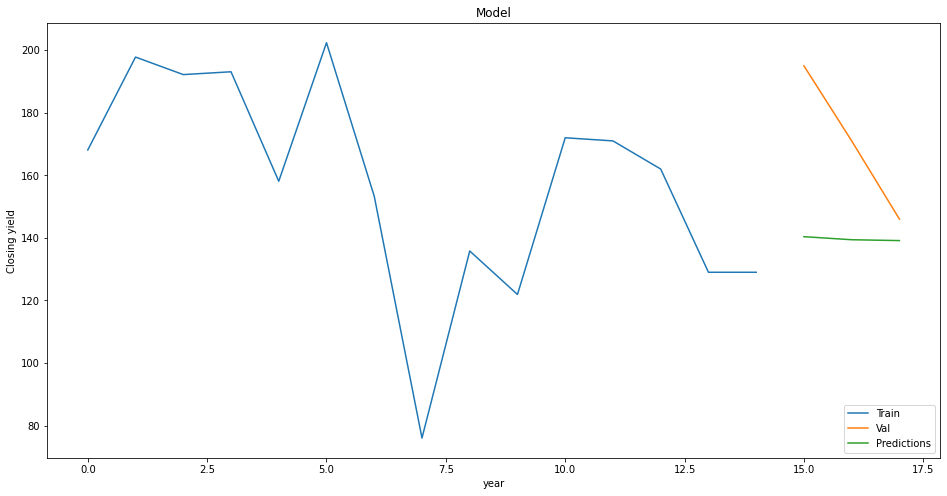

In [44]:
train = data[:training_split]
valid = data[training_split:]
valid['Predictions'] = predictions
plt.figure(figsize =(16,8))
plt.title('Model')
plt.xlabel('year',fontsize = 10)
plt.ylabel('Closing yield', fontsize = 10)
plt.plot(train['yield'])
plt.plot(valid[['yield', 'Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show()

In [45]:
predictions

array([[140.3747 ],
       [139.40005],
       [139.12541]], dtype=float32)